# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 
                                  'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('zillow_data.csv')
df.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600


# Step 2: Data Preprocessing

In [4]:
# create a new dataframe with the difference between the values in recent years after the housing crisis
series09 = df['2009-04']
series18 = df['2018-04']
zipcode = df['RegionName']

# add the difference and noramalize it
diff_df = pd.concat([zipcode, series09, series18], axis=1)
diff_df['diff'] = (diff_df['2018-04'] - diff_df['2009-04'])/diff_df['2009-04']*100

# diff_df.hist('diff',bins=20, density=True)

In [5]:
cutoffs = [diff_df['diff'].quantile(0.025),
          diff_df['diff'].quantile(0.975)]
cutoffs

[-12.397226464387554, 84.68906545566401]

In [65]:
#  December 2007 – June 2009 find the zip codes that remained the most stable during the house crisis.
series07 = df['2007-12']
series18 = df['2009-06']
zipcode = df['RegionName']
stability_df = pd.concat([zipcode, series07, series18], axis=1)
stability_df['diff'] = (stability_df['2007-12'] - stability_df['2009-06'])/stability_df['2007-12']*100
stability_df.head()

,RegionName,2007-12,2009-06,diff
0,60657,887000.0,786900.0,11.285231
1,75070,214100.0,199700.0,6.725829
2,77494,254600.0,246800.0,3.063629
3,60614,1167900.0,1010200.0,13.502868
4,79936,132000.0,119100.0,9.772727


In [6]:
# # Scale the values
# scaler = MinMaxScaler()
# melt_df[['value']] = scaler.fit_transform(melt_df[['value']])

In [7]:
# grab the zip codes that exist between the cutoff values
# zips_model_1 = diff_df[diff_df['diff']<cutoffs[0]]['RegionName']
zips_model_10 = diff_df[diff_df['diff']>cutoffs[1]]['RegionName']

In [8]:
melt_df = melt_data(df)
melt_df.set_index('time', inplace=True)
melt_df.drop(['RegionID', 'SizeRank'], inplace=True, axis=1)
# melt_df.head()

In [9]:
# sort by zip code and date
sorted_melt = melt_df.sort_values(['RegionName', 'time'])
sorted_melt = sorted_melt[sorted_melt.index >= '2009-04-01']
# sorted_melt.head()

In [10]:
# split the data for testing and training purposes
train_df = sorted_melt[sorted_melt.index < '2016-04-01']
test_df = sorted_melt[sorted_melt.index >= '2016-04-01']

In [12]:
# training model
high_return = train_df.loc[train_df['RegionName'].isin(list(zips_model_10))]
# low_return = train_df.loc[train_df['RegionName'].isin(list(zips_model_1))]

In [13]:
# dataframes to reflect the zip codes with the highest
high_df = high_return.groupby('time')[['value']].mean()
# low_df = low_return.groupby('time')[['value']].mean()

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

(array([468, 480, 492, 504, 516, 528, 540, 552]),
 <a list of 8 Text xticklabel objects>)

D:\Programs\Anaconda\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


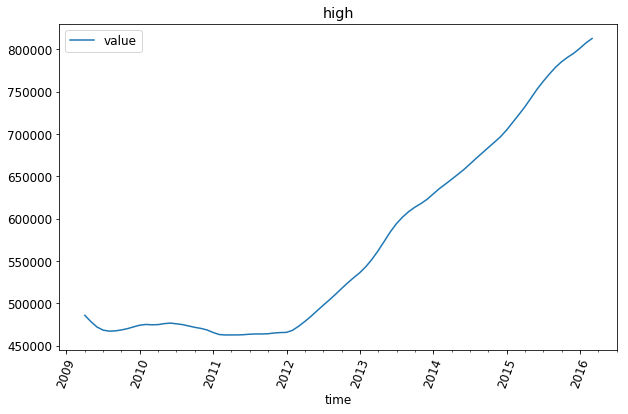

In [14]:
font = {'family' : 'normal',
        'size'   : 12}
plt.rcParams['figure.figsize'] = 10, 6
plt.rc('font', **font)
high_df.plot()
plt.title('high')
plt.xticks(rotation=70)
# low_df.plot()
# plt.title('low')
# plt.xticks(rotation=70)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [ ]:
# Check for stationarity

In [15]:
# dickey fuller test
from statsmodels.tsa.stattools import adfuller
def dickey_fuller(array):
    test = adfuller(array)
    output = pd.Series(test[0:4], index = ['Test Stat','p-value','# Lags used', '# of obs'])
    return output

Test Stat      -1.485414
p-value         0.540714
# Lags used     4.000000
# of obs       78.000000
dtype: float64

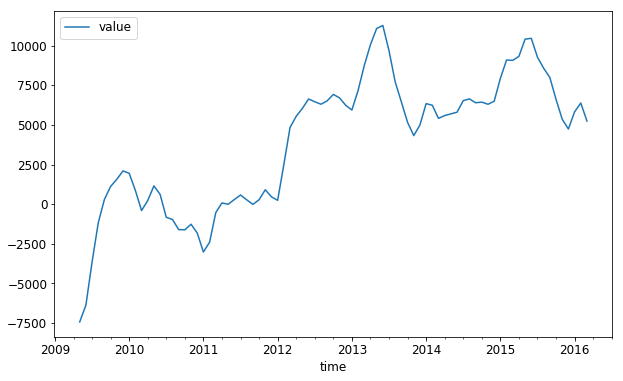

In [16]:
# High ROI zipcodes
#differenced once
high_df_once = high_df.diff()
high_df_once.dropna(inplace=True)
high_df_once.plot()

dickey_fuller(high_df_once.value)

Test Stat      -5.160902
p-value         0.000011
# Lags used     3.000000
# of obs       78.000000
dtype: float64

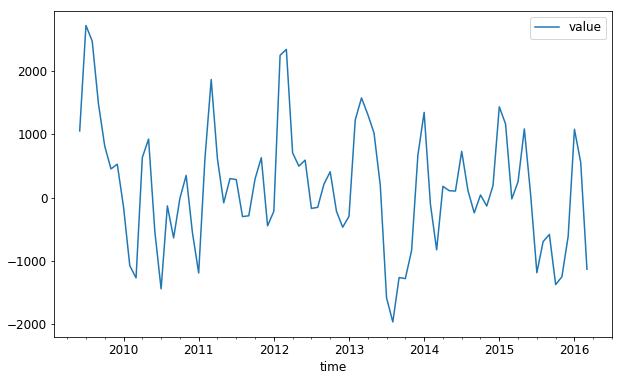

In [17]:
#differenced twice
high_df_twice = high_df_once.diff()
high_df_twice.dropna(inplace=True)
high_df_twice.plot()


#run dicky fuller
dickey_fuller(high_df_twice.value)

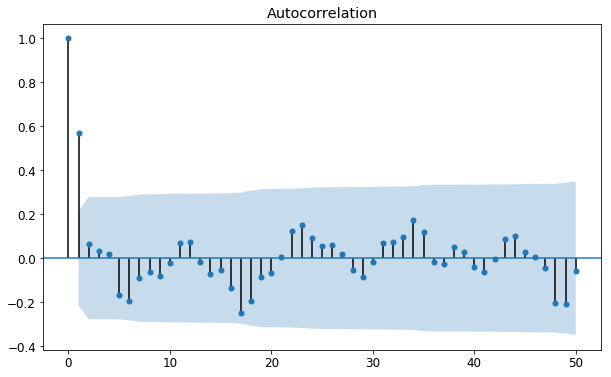

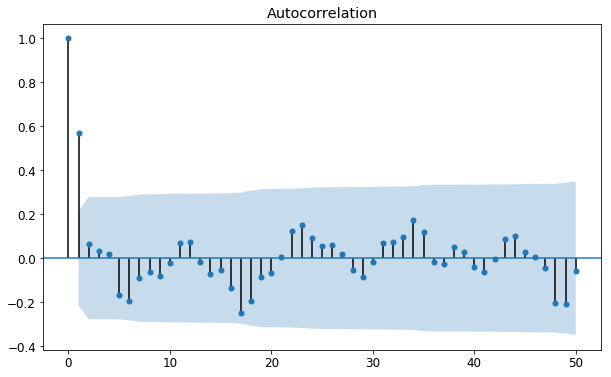

In [18]:
# check auto correlation and determine the order of MA
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(high_df_twice, alpha=.05, lags=50)

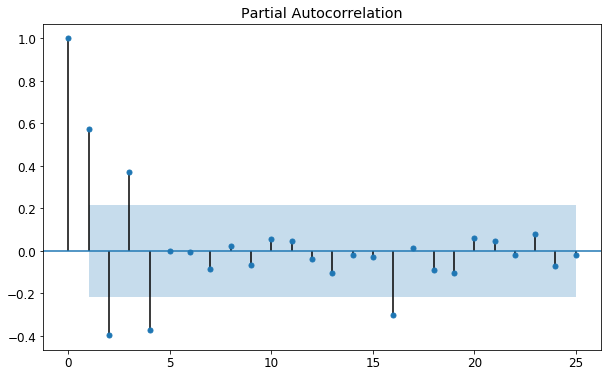

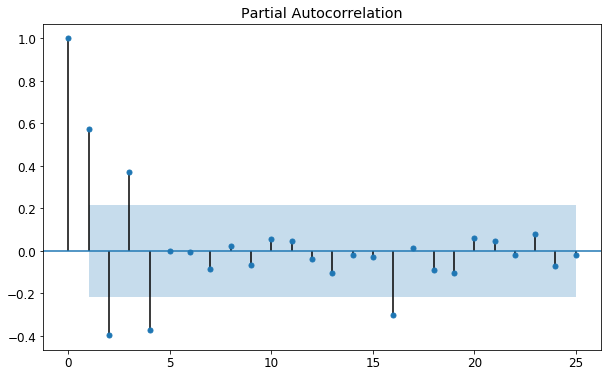

In [19]:
# plot the partial auto correlations to determine AR order
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(high_df_twice, alpha=.05, lags=25)

In [ ]:
start_date = '2009-04-01'
end_date = '2018-04-01'

In [ ]:
# # LOW ROI zipcodes
# #differenced once
# low_df_once = low_df.diff()
# low_df_once.plot()

# #differenced twice
# low_df_twice = low_df_once.diff()
# low_df_twice.dropna(inplace=True)
# low_df_twice.plot()

# #run dicky fuller
# dickey_fuller(low_df_twice.value)

In [ ]:
plot_acf(low_df_twice, alpha=.05, lags=25)

In [ ]:

plot_pacf(low_df_twice, alpha=.05, lags=25)

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

In [51]:
#fit ARIMA model (p,d,q))
from statsmodels.tsa.arima_model import ARIMA

In [58]:
#ARIMA model for high ROI

high_model = ARIMA(high_df_twice, order=(4,0,0))
high_model_fit = high_model.fit(disp=0)
print(high_model_fit.summary())

D:\Programs\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Programs\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\Programs\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\Programs\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1350:

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   82
Model:                     ARMA(4, 0)   Log Likelihood                -644.295
Method:                       css-mle   S.D. of innovations            618.228
Date:                Thu, 05 Sep 2019   AIC                           1300.589
Time:                        17:16:05   BIC                           1315.030
Sample:                    06-01-2009   HQIC                          1306.387
                         - 03-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         128.7697    131.042      0.983      0.329    -128.068     385.608
ar.L1.value     1.1106      0.103     10.751      0.000       0.908       1.313
ar.L2.value    -1.0014      0.141     -7.088    

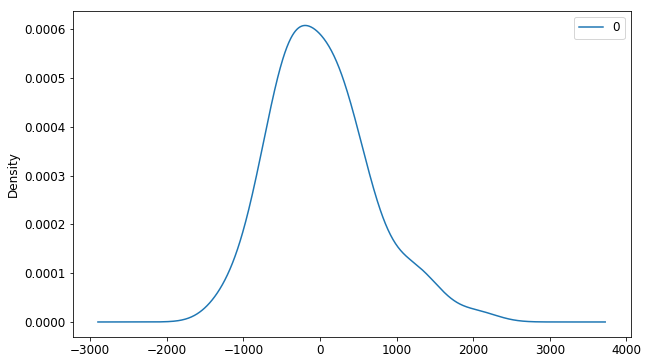

In [59]:
residuals = pd.DataFrame(high_model_fit.resid)
residuals.plot(kind='kde')
high_model_fit

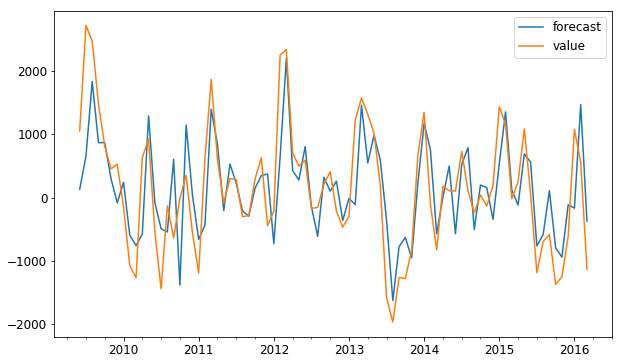

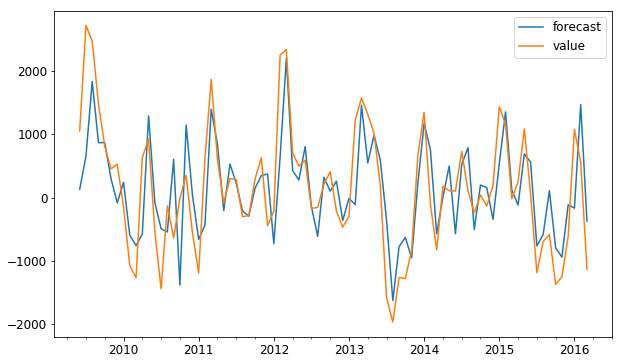

In [60]:
# high_model_fit.plot_predict()

In [61]:
# predict the next 2 years 
y_hat = high_model_fit.forecast(108)[0]
y_hat = y_hat[83:]
y_hat

array([128.76974431, 128.76972716, 128.7697014 , 128.76971753,
       128.76973156, 128.76971825, 128.76971142, 128.76972148,
       128.76972413, 128.76971698, 128.76971656, 128.76972138,
       128.76972077, 128.7697177 , 128.76971867, 128.76972052,
       128.76971953, 128.76971849, 128.76971934, 128.76971987,
       128.76971921, 128.76971898, 128.76971946, 128.76971952,
       128.76971919])

In [62]:
y_obs_means['value'][1]-y_obs_means['value'][2]

-1336.4463764178508

In [63]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
# average the values per year
y_obs_means = test_df.groupby('time')[['value']].mean()
 
# difference the test data
y_obs = y_obs_means[['value']]
# y_obs_diff1 = y_obs.diff()
# y_obs_diff2 = y_obs_diff1.diff()
# y_obs.dropna(inplace=True)


RMSE = sqrt(mse(y_obs_means, y_hat))
# RMSE

# plt.plot(y_obs_means, color='red')
# plt.plot(y_hat, color='orange')
RMSE

269310.34378333134

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.